# Redes Neuronales con PyTorch para Regresión (California Housing)

Compararemos el rendimiento de nuestros modelos de redes neuronales con un
modelo RandomForest previamente entrenado que alcanzó un RMSE de aproximadamente 41000 dólares.

## Configuración inicial

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
import os

In [2]:
RANDOM_STATE = 42

np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)

# Determinar el dispositivo (GPU si está disponible, si no CPU)
if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed(RANDOM_STATE) # Inicializa la semilla para la GPU
else:
    device = torch.device("cpu")
    
print(f"\nUsando dispositivo: {device}")


num_workers = os.cpu_count() // 2 # Número de workers. La mitad de los núcleos disponibles (heuristico común)


Usando dispositivo: cuda


## Carga de datos

In [3]:
from utils.load_california import load_housing_data

VAL_SIZE = 0.2

X_train_full, X_test, y_train_full, y_test = load_housing_data()

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=VAL_SIZE, random_state=RANDOM_STATE
)

Hemos separado un conjunto de validación. Por simplicidad no haremos *cross-validation* ya que es una práctica menos habitual en *deep learning* porque se suelen usar más datos para entrenamiento y con esto aumenta el costo computacional. sin embargo, en este caso, no se trata de tantos datos y sería abordable.

## Preprocesamiento de datos

Se importan las funciones de preprocesamiento necesarias que se han definido en el fichero `housing_preprocessing.py`. El pipeline debe ser **ajustado (fitted)** *únicamente* con los datos de **entrenamiento** (`X_train`) para evitar fuga de información. Luego, se usa para **transformar** los otros conjuntos.

Después del preprocesamiento, convertiremos los datos de NumPy arrays a **Tensores de PyTorch**, que son la estructura de datos fundamental en PyTorch.

Para el número de clusters de la similitud geoespacial, se ha usado el valor que mejores resultados dio en [la búsqueda de hiperparámetros](../e2e081_hyperparameters_tarea.ipynb).

In [4]:
from utils.housing_preprocessing import get_preprocessing_pipeline

preprocessing_pipeline = get_preprocessing_pipeline(n_clusters=76)

# Ajustar el pipeline CON SOLO los datos de entrenamiento
preprocessing_pipeline.fit(X_train)

# Aplicar el pipeline para transformar los datos de entrada
X_train_processed = preprocessing_pipeline.transform(X_train)
X_val_processed = preprocessing_pipeline.transform(X_val)
X_test_processed = preprocessing_pipeline.transform(X_test)

La normalización de *features* es esencial para redes neuronales porque al llevar todos los atributos a escalas comparables se evita que aquellos con magnitudes mayores dominen el cálculo de gradientes, lo que acelera la convergencia de los algoritmos de optimización y mejora la estabilidad numérica al prevenir fenómenos de desbordamiento o gradientes “muertos” en las regiones planas de funciones de activación. En este caso, el *pipeline* de preprocesamiento ya estandariza las variables de entrada.

Asimismo, normalizar la variable objetivo en tareas de regresión contribuye a que la función de coste opere en un rango razonable, facilita pasos de actualización más coherentes durante el aprendizaje y puede mejorar tanto la velocidad de convergencia como la calidad final del modelo.

In [5]:
from utils.housing_preprocessing import scale_target
y_train_scaled_np, y_val_scaled_np, y_test_scaled_np, y_scaler = scale_target(y_train, y_val, y_test)

## Definición de métrica de evaluación (y de la función de pérdida)

Previamente se ha definido la métrica de evaluación (RMSE). Por lo que para un modelos de redes neuronales, usaremos la función de pérdida `nn.MSELoss()`. Minimizar el MSE es equivalente a minimizar el RMSE. Usaremos el RMSE para evaluar el modelo con un valor más interpretable.

In [6]:
criterion = nn.MSELoss() # Para las redes neuronales con PyTorch

## Baseline: Random Forest

Partimos de un modelo Random Forest con los mejores hiperparámetros encontrados previamente; con estos se conseguía un RMSE de 41604 USD usando *cross-validation*.

In [7]:
# %%script false --no-raise-error # Para saltarse una celda en ejecución

from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(
    n_estimators=290,
    max_depth=87,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=RANDOM_STATE,
    n_jobs=num_workers
)
rf_model.fit(X_train_processed, y_train)
y_val_pred = rf_model.predict(X_val_processed)
val_rmse = root_mean_squared_error(y_val, y_val_pred)

print(f"Random Forest RMSE: {val_rmse:.2f}")

Para el conjunto de validación definido en este caso, el modelo Random Forest alcanza un RMSE de **44711 USD. Este será nuestro valor de referencia** para comparar con los modelos de redes neuronales.

## Comparación con modelos de Redes Neuronales

### Preparación de los datos

In [8]:
# Convertir los datos NumPy a Tensores de PyTorch y moverlos a GPU si está disponible
X_train_tensor = torch.tensor(X_train_processed.astype(np.float32)).to(device)
X_val_tensor = torch.tensor(X_val_processed.astype(np.float32)).to(device)
X_test_tensor = torch.tensor(X_test_processed.astype(np.float32)).to(device)

# Determinar el número de features de entrada para la red
n_features = X_train_tensor.shape[1]
print(f"Número de features de entrada: {n_features}")

y_train_tensor = torch.tensor(y_train_scaled_np.astype(np.float32)).to(device)
y_val_tensor = torch.tensor(y_val_scaled_np.astype(np.float32)).to(device)
y_test_tensor = torch.tensor(y_test_scaled_np.astype(np.float32)).to(device)

Número de features de entrada: 90


Utilizamos la clase `TensorDataset` para crear un dataset a partir de los tensores de características y etiquetas. Luego, utilizamos la clase `DataLoader` para crear un `DataLoader` a partir del dataset. El `DataLoader` nos permite iterar sobre el dataset en *batches*, barajando los datos en cada *epoch*.

In [9]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 512

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

## Modelo 1: MLP Simple

In [10]:
class SimpleMLP(nn.Module):
    def __init__(self, n_features):
        super().__init__()
        self.layer1 = nn.Linear(n_features, 128)
        self.relu1 = nn.ReLU()
        self.layer2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.layer3 = nn.Linear(64, 32)
        self.relu3 = nn.ReLU()
        self.output_layer = nn.Linear(32, 1)

    def forward(self, x):
        x = self.relu1(self.layer1(x))
        x = self.relu2(self.layer2(x))
        x = self.relu3(self.layer3(x))
        x = self.output_layer(x)
        return x
    
model1 = SimpleMLP(n_features).to(device)
optimizer = optim.Adam(model1.parameters(), lr=0.001)

Starting detailed training on 'cuda' for 100 epochs...
Epoch [10/100] - 0.19s | Train RMSE: 51534 | Val RMSE: 52054
Epoch [20/100] - 0.19s | Train RMSE: 48392 | Val RMSE: 50389
Epoch [30/100] - 0.20s | Train RMSE: 47006 | Val RMSE: 50804
Epoch [40/100] - 0.19s | Train RMSE: 46520 | Val RMSE: 50794
Epoch [50/100] - 0.20s | Train RMSE: 44294 | Val RMSE: 49852
Epoch [60/100] - 0.19s | Train RMSE: 43028 | Val RMSE: 49682
Epoch [70/100] - 0.19s | Train RMSE: 43582 | Val RMSE: 49699
Epoch [80/100] - 0.19s | Train RMSE: 41035 | Val RMSE: 50446
Epoch [90/100] - 0.19s | Train RMSE: 40782 | Val RMSE: 50445
Epoch [100/100] - 0.19s | Train RMSE: 39724 | Val RMSE: 48855

Detailed training finished in 20.87 seconds.


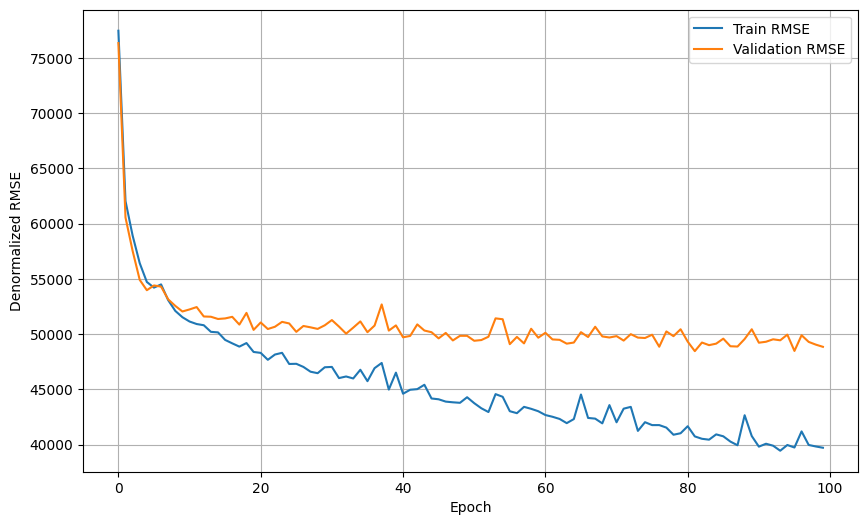

In [11]:
from utils.training_utils import train_model_detailed, plot_metrics

num_epochs = 100

metrics1 = train_model_detailed(
    model=model1, 
    train_loader=train_loader, 
    val_loader=val_loader, 
    criterion=criterion, 
    optimizer=optimizer, 
    y_scaler=y_scaler, 
    num_epochs=num_epochs, 
    device=device,
    print_every=10 # Print metrics every 10 epochs
)

plot_metrics(metrics1)

## Modelo 2: Red Neuronal con Dropout

In [12]:
import torch.nn as nn
import torch.nn.functional as F

class Model2(nn.Module):
    def __init__(self, n_features):
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(n_features, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.3),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.3),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.2),

            nn.Linear(64, 1)  # single‐value regression
        )

    def forward(self, x):
        return self.net(x)
    
model2 = Model2(n_features).to(device)
optimizer = optim.Adam(model2.parameters(), lr=0.001)

Starting detailed training on 'cuda' for 100 epochs...
Epoch [10/100] - 0.25s | Train RMSE: 51868 | Val RMSE: 51764
Epoch [20/100] - 0.25s | Train RMSE: 49742 | Val RMSE: 50439
Epoch [30/100] - 0.23s | Train RMSE: 48385 | Val RMSE: 49730
Epoch [40/100] - 0.26s | Train RMSE: 46452 | Val RMSE: 48439
Epoch [50/100] - 0.24s | Train RMSE: 45879 | Val RMSE: 48808
Epoch [60/100] - 0.26s | Train RMSE: 45218 | Val RMSE: 48304
Epoch [70/100] - 0.25s | Train RMSE: 44141 | Val RMSE: 47573
Epoch [80/100] - 0.22s | Train RMSE: 43310 | Val RMSE: 47622
Epoch [90/100] - 0.22s | Train RMSE: 42741 | Val RMSE: 46536
Epoch [100/100] - 0.21s | Train RMSE: 42460 | Val RMSE: 47375

Detailed training finished in 24.68 seconds.


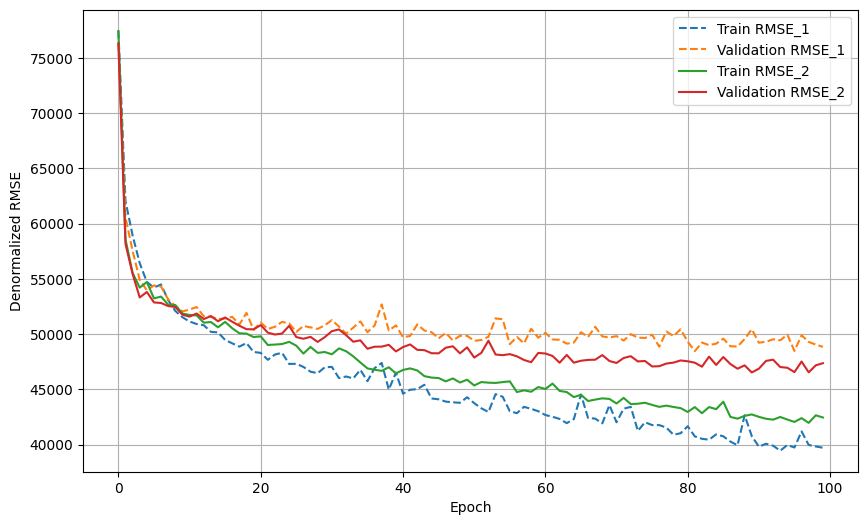

In [14]:
metrics2 = train_model_detailed(
    model=model2, 
    train_loader=train_loader, 
    val_loader=val_loader, 
    criterion=criterion, 
    optimizer=optimizer, 
    y_scaler=y_scaler, 
    num_epochs=num_epochs, 
    device=device,
    print_every=10 # Print metrics every 10 epochs
)

plot_metrics(metrics1, metrics2)

Se observa que los nuevos modelos no consiguen mejorar el RMSE de referencia.

Sin embargo, hay que tener en consideración que para el modelo Random Forest se hizo un ajuste de hiperparámetros con *cross-validation* y que el modelo de redes neuronales no ha sido ajustado.